In [1]:
import sys
sys.path.append('scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
# 3σ範囲の楕円を求める
def sigma_ellipse(p, cov, n): 
    # 共分散行列から固有値と固有ベクトルを計算
    eig_vals, eig_vec = np.linalg.eig(cov)
    
    #楕円の傾き(2つの固有ベクトルがなす角度)を計算
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    
    #楕円のオブジェクトを返す
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5) 

In [3]:
# カルマンフィルタ
class KalmanFilter: ###kf4init
    # 変数
    # envmap:地図 
    # init_pose:初期姿勢
    # motion_noise_stds:雑音
    
    # distance_dev_rate:雑音の割合(0.14)
    # distance_dev: 雑音の標準偏差(0.5)
    # それぞれの値を大きくするとランドマークを観測していても誤差楕円が大きくなる。
    # それぞれの値を小さくするとランドマークを観測していないときに誤差楕円は少しだけ大きくなるが、
    # ランドマークを観測すると急激に小さくなる。楕円の中心がロボットの現在座標から大きくずれる。
    
    
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.5): #変数追加
        # 多次元ガウス分布の生成
        # mean:平均, cov:共分散行列
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) 
        
        # インスタンス変数に引数を入れる
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  #追加
        for d in observation:
            # 観測値
            z = d[0]
            obs_id = d[1]
            
            ###Hの計算###
            # h(x):誤差楕円に属するロボットとランドマークの相対的な姿勢
            # Hの役割:h(x)を線形化するために近似する行列
            # 計測対象のランドマークの座標を取得
            mx, my = self.map.landmarks[obs_id].pos
            
            # 誤差楕円の平均μを取得
            mux, muy, mut = self.belief.mean
            
            # ランドマークの座標と平均μの距離を計算
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            
            # Hを算出
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            # Qの役割：雑音を考慮するため
            # 誤差楕円の中心とランドマークの距離と方角を取得
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            # 取得した距離から雑音の標準偏差を算出
            distance_dev = self.distance_dev_rate*hmu[0]
            # ばらつきの標準偏差から共分散行列を算出
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            # ここでいままで算出したHとQを用いてカルマンゲインKを算出
            # Kの役割:ランドマークを観測した後、観測結果を誤差楕円に反映させるための行列
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            # 現在の誤差楕円の平均値と共分散行列に算出したカルマンゲインを用いて更新する
            self.belief.mean += K.dot(z - hmu)
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
        
    def motion_update(self, nu, omega, time): #追加
        #　角速度が0になると解き方が変わるので、代わりに小さい値を入れておく
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
        #　並進速度が0になると解き方が変わるので、代わりに小さい値を入れておく
        if abs(nu) < 1e-5:         nu = 1e-5
        
        # 雑音の標準偏差のリストを持ってくる
        v = self.motion_noise_stds
        # 雑音に関するガウス分布の共分散行列を計算
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        # 現在のロボットの姿勢から方角を取得
        t = self.belief.mean[2]
        # 取得した方角からsin,cosを算出
        st, ct = math.sin(t), math.cos(t)
        # 現在のロボットの姿勢の方角から微小時間後の方角のsin,cosの算出
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)
        # 遷移後の姿勢を得るための行列を算出
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        # 3*3の単位行列
        F = np.diag([1.0, 1.0, 1.0])
        # 状態遷移関数f(x)を線形化するための近似する行列
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
        
        # 雑音を考慮しない場合の状態遷移に対応した誤差楕円の更新
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [8]:
# エージェント(ロボット)にカルマンフィルタを実装
class KfAgent(Agent): 
    # time_interval=周期[s]
    # nu=並進速度[m/s]
    # omega=角速度[rad/s]
    # init_pose=初期の位置(x,y)
    # envmap=地図情報
    # motion_noise_stds=雑音の標準偏差のリスト
     # nn:直進時の直進方向のばらつきの標準偏差(値を上げると直進方向に誤差楕円の中心がずれやすくなる)
     # no:直進時の回転方向のばらつきの標準偏差()
     # on:回転時の直進方向のばらつきの標準偏差
     # oo:回転時の回転方向のばらつきの標準偏差
    # motion_noise_stdsの値をいじると誤差楕円の分散や平均が変動する
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        # 親クラス(Agent)からinitを継承
        super().__init__(nu, omega)
        # カルマンフィルタクラスのインスタンス化
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds)
        # 周期[s]
        self.time_interval = time_interval
        # 並進速度と角速度の初期化
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):  ###kfagent2
        # 移動後の更新
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        # 現在の並進速度と角速度を保存
        self.prev_nu, self.prev_omega = self.nu, self.omega
        # 観測後の更新
        self.kf.observation_update(observation)   #追加
        # 現在の並進速度と角速度を返す
        return self.nu, self.omega
        
    def draw(self, ax, elems): #追加
        # 描画
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


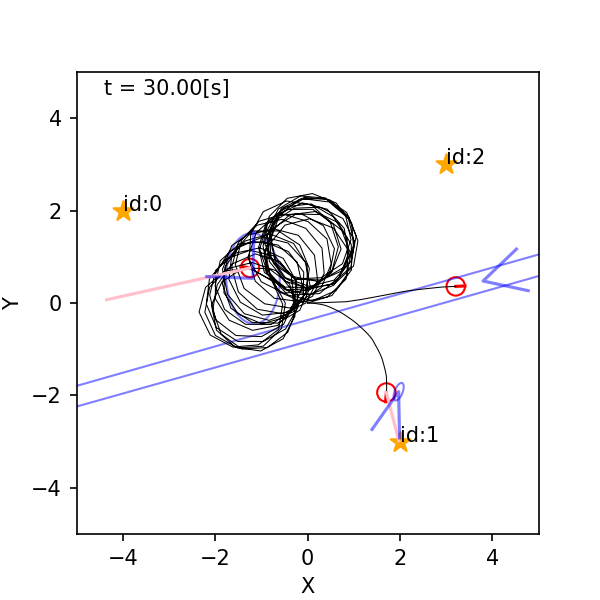

In [9]:
if __name__ == '__main__': 
    # 0.1秒周期
    time_interval = 0.1
    # 30秒動作させる,ワールドの定義
    world = World(30, time_interval)

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    # (-4,2)にランドマークを設置
    m.append_landmark(Landmark(-4,2))
    # (-2,3)にランドマークを設置
    m.append_landmark(Landmark(2,-3))
    # (3,3)にランドマークを設置
    m.append_landmark(Landmark(3,3))
    # ランドマークをワールドに追加
    world.append(m)          

    ### ロボットを作る ###
    # 並進速度ν:0.2 角速度ω:π/18
    circling = KfAgent(time_interval, 5, 360/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットの変数を定義
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    # ワールドに追加
    world.append(r)
    
    # 並進速度ν:0.1 角速度ω:0
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    # ロボットの変数を定義
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    # ワールドに追加
    world.append(r)
    
    # 並進速度ν:0.1 角速度ω:-π/60
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットの変数
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    # ワールドに追加
    world.append(r)
    
    # ランドマークを観測していない時、並進速度や角速度を大きい方が誤差楕円の分散が大きくなり、平均値がロボットの中心座標とずれる
    
    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき